# Preference Trick - Part 1

In this document we show our first tentative to calculate the preferance matrix of Soft Linkage. 

We start with an image of relevant points taken from the **Jiqing Expressway Dataset** and we show the result of line detection using the **Extended Hough Transform**. In particular we show the correlation of this result to Kmeans cluster technique.

Then we build the preference matrix that we will use for Soft Linkage.


### Our Approach to calculate the Preference Matrix

The main idea of our calculation of the preference matrix is the following:
* Start with DBScan clustering to extract the initial clusters which indicates the presence of a simil-line
* For each point *p* calculate its preference on the cluster *C* in this way:
    - calculate the parabola (**model**) passing through the point of cluster *C*
    - calculate the error of *p* to be considered a point of this cluster *C* as the following:
        * `err = | y_point - parabola(x_point)|`
 


In [1]:
### import libraries
import os
import cv2 as cv2
import numpy as np
import json  as json
import imutils
import math
from matplotlib import pyplot as plt

path_dataset = './dataset/bilboards/'

def iread(img_path, resize_width=None):
    img = cv2.imread(path_dataset + img_path)
    if resize_width is not None:
        img = imutils.resize(img, width=resize_width)
    return img

def iinfo(img):
    print("[IMAGE] height: {} x width: {} x channels: {} - data type: {}".format(
        img.shape[0], 
        img.shape[1], 
        (img.shape[2] if img.ndim > 2 else 0),
        img.dtype))

## Preface - Hough Extended Transform 

We start performing Hough Extended Transform in a frame extracted from  **Jiqing Expressway Dataset**.

Unfortunatly the lanes of the road, that have been tagged with their ground trouth in this dataset, don't show relevant radial distortion, so using them for this experiment it would not be so interesting. 

We decide to take in consideration the electrical wires of the road. Infact these wires in the video are almost lines but when the car is passing through them, they are heavily subject to radial distorted and they are perceved as parabolas due to the barrel effect. 

So we formulate our first assumption:

`The electrical wires shown on the image, are **lines** representation in the radial distorted space.` 

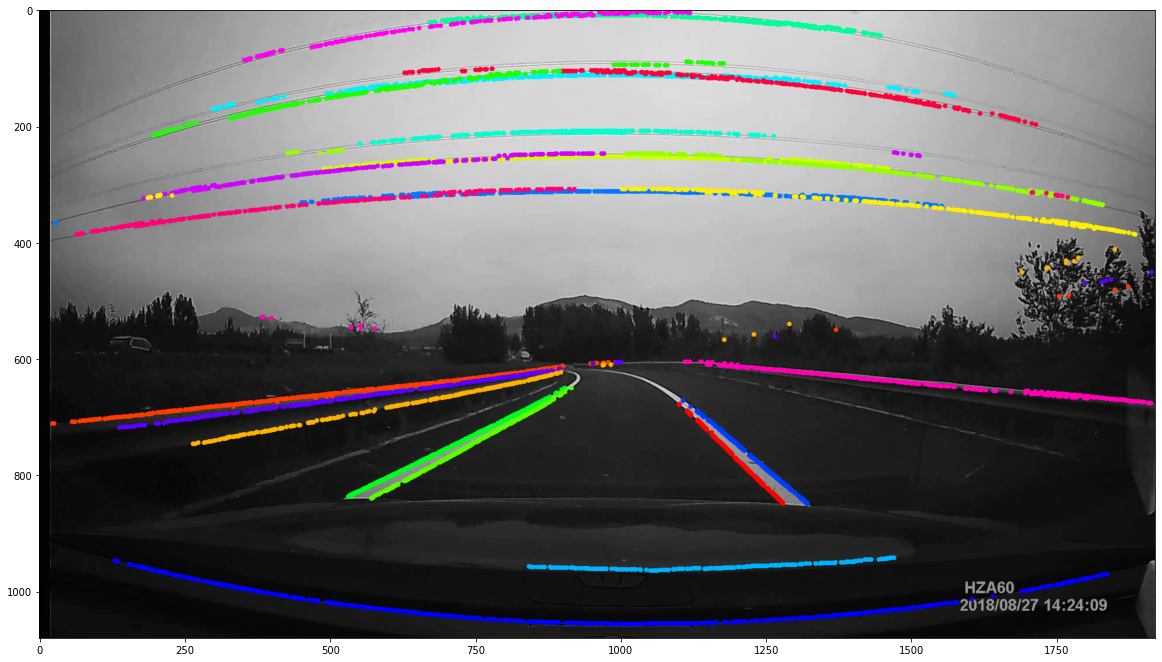

In [2]:
nemesis = iread('dataset_IMG_0249_18.png')
plt.figure(figsize = (20,20))
plt.imshow(nemesis)

### Starting Point - Edges 

To have the same starting point of **The Hough Extendend Transform** we use as input image the edges points extracted by the same algorithm.

Fortunately, the implementation of the **The Hough Extendend Transform** that we are using provides as output an image of the edges.


[IMAGE] height: 1080 x width: 1920 x channels: 0 - data type: uint8


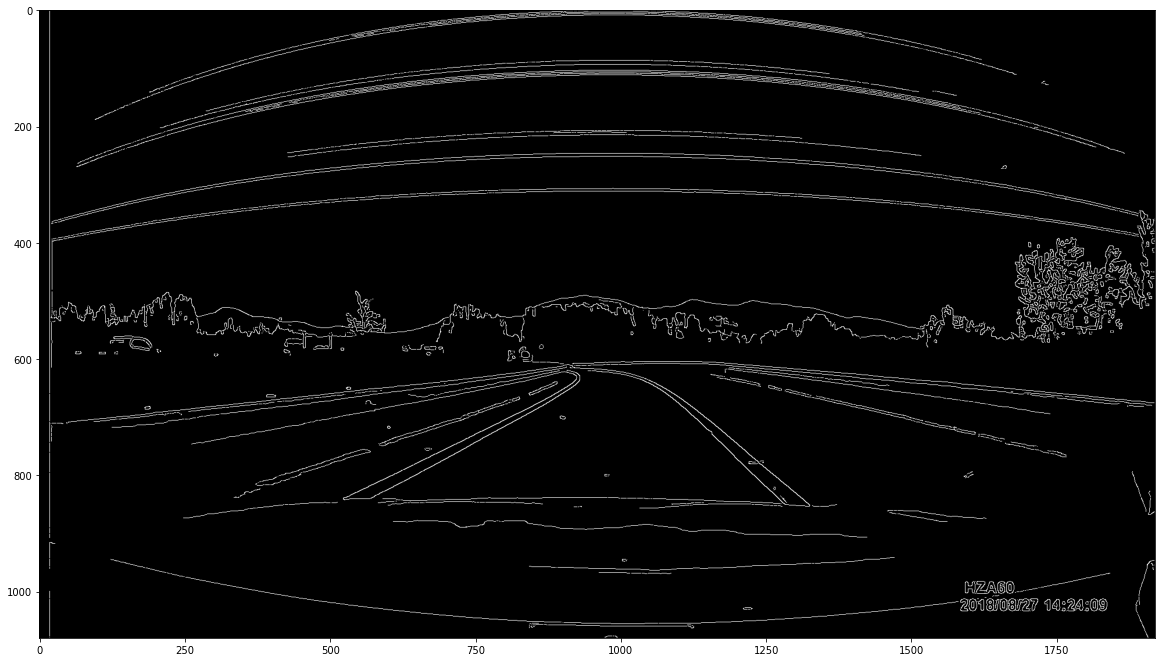

In [3]:
edges_rgb   = iread('dataset_IMG_0249_18_canny.png')
edges_white = cv2.cvtColor(edges_rgb, cv2.COLOR_BGR2GRAY)
edges = cv2.bitwise_not(edges_white)

plt.figure(figsize=(20,20))
plt.imshow(edges, cmap='gray')
iinfo(edges)

### Extract The Region of Interest

From the edges image we crop the roi (region of interest) in which we want to perform our experiments.

In this case, our roi cointains the electrical wires of the road

[IMAGE] height: 420 x width: 1920 x channels: 0 - data type: uint8


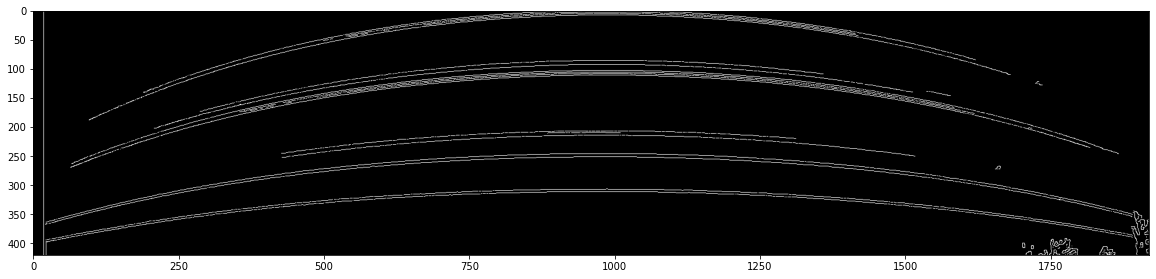

In [4]:
roi=edges[0:420, 0:]
plt.figure(figsize=(20, 20))
plt.imshow(roi, cmap='gray')
iinfo(roi)

## Clustering with KMeans and correlation with Extended Hough Transform

Before starting with preference matrix calculation, we perform KMeans clustering and we show that the result has the same defects that are visible in the Extended Hough Transform.

In this particular approach seems quite difficult to detect fully the parabola curve and it seems that a break in the curve its almost needed.


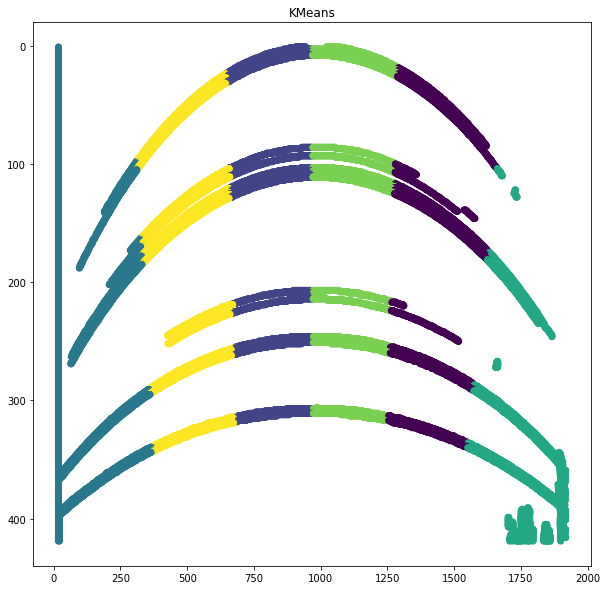

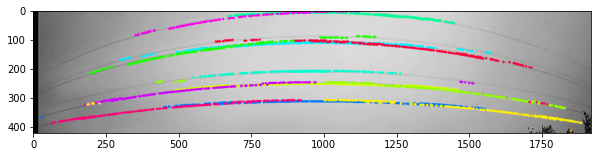

In [5]:
from sklearn.cluster import DBSCAN, KMeans

# some numpy tricks
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points

y_pred = KMeans(n_clusters=6, random_state=10000).fit_predict(pts)
plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
plt.scatter(pts[:, 0], pts[:, 1], c=y_pred)
plt.title('KMeans')

plt.figure(figsize=(10, 10))
roi_nemesis=nemesis[0:420, 0:]
plt.imshow(roi_nemesis)

# Calculculation of the Preference Matrix

### 1.0 Clustering with DBSCAN

From the roi extracted now we perform Dbscan.
We perform this task because we want to dimonstrate that with data effected by radial distortion a soft clustering approach is prefered.

In [6]:
from sklearn.cluster import DBSCAN, KMeans

# Clusters Utils

def get_cluster_pts(pts_clusters, cluster_label):
    return np.where(pts_clusters == cluster_label)[0]

def print_cluster(cluster_pts, pts, label, color="b"):
    coords = np.take(pts, cluster_pts, axis=0)
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 1920)
    plt.ylim(420, 0)
    plt.scatter(coords[:, 0], coords[:, 1], 1, c=color)
    plt.title('Cluster {}'.format(label))
    
def info_cluster(cluster_label, cluster_pts):
    print("cluster {}] num of points:\t{}".format(cluster_label, cluster_pts.shape[0]))

def clusterize(pts, debug=True):
    db = DBSCAN(eps=3.5, min_samples=4).fit(pts)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        plt.scatter(pts[:, 0], pts[:, 1], c=db.fit_predict(pts))
        plt.title('DBSCAN')

    pts_clusters=db.fit_predict(pts)
    num_clusters   = np.unique(pts_clusters).shape[0]
    clusters_label = np.unique(pts_clusters)
    if debug:
        print("num_clusters:\t {}\ncluster labels:\n {}".format(num_clusters, clusters_label))
    return pts_clusters, num_clusters, clusters_label

def get_all_clusters(pts):
    clusters = {}
    pts_clusters, num_clusters, clusters_label = clusterize(pts, debug=False)
    for l in clusters_label:
        clusters.update({l: get_cluster_pts(pts_clusters, l)})
    return clusters

### 2.0 Add Noise (25% of the data)

Soft Linkage is a robust algorithm.

In this experiment we add random noise on the input data so that the final solution does not correspond to a DBScan solution.

Here we have some functions that add noise to the input points

In [7]:
# Noise Utils

def get_random(pts, qty_noise=1000, debug=False):
    noise = np.random.randint(low=(0, 0), high=(roi.shape[1], roi.shape[0]), size=(qty_noise, 2))
    print("num of pts {}, num of noise {}".format(pts.shape[0], noise.shape[0]))
    noise_x = noise[:, 0]
    noise_y = noise[:, 1]

    if debug:
        plt.figure()
        plt.scatter(noise_x, noise_y)
        plt.title('Random Data')
    return noise

def add_random(pts, noise, debug=False):
    pts_new = pts.copy()
    pts_new = np.concatenate([pts_new, noise])
    if debug:
        print ("num of points with random {}".format(pts.shape[0]))
        plt.figure()
        plt.scatter(new_pts[:, 0], new_pts[:, 1])
        plt.title('Experiment Points')
    
    return pts_new

### 3.0 - Point Preference Evaluation

The preference of the point for a cluster is calculated as the distance of the point to the parabola that approximate the cluster.


For the approximation of the cluster we perform polynomial regression using Chebyshev polinomy.
For semplicity we specify a degree 2 such that `the models will be parabolas`, which could be a first tentative to represent the **barrel effect** which lines are subjected in a radial distortion space. 


In [8]:
from numpy.polynomial import Chebyshev as T

def evaluate(point, cluster_pts, all_pts, debug=True):
    # evaluate the approximation
    coords = np.take(all_pts, cluster_pts, axis=0)
    
    x = coords[:, 0]
    y = coords[:, 1]
    parabola = T.fit(x, y, deg=2, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, parabola(x_axis), 'b')
        
    # point
    xp     = point[0] 
    yp     = point[1]
    approx = parabola(xp)
    err    = np.abs(approx - yp)

    if debug:
        plt.plot(xp, yp, 'g.', markersize=10)
        plt.show()
    
    return err

### Execution
we extract the input points and we add random noise.

Then we perform DBScan. Here are shown our clustering result in a noisy environment

num of points (23003, 2)
num of pts 23003, num of noise 1150
num of points with random 24153


Text(0.5, 1.0, 'Experiment Points')

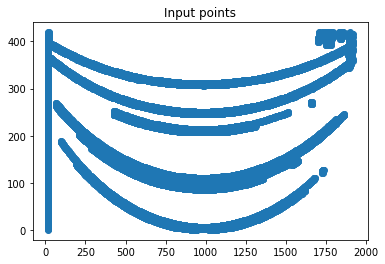

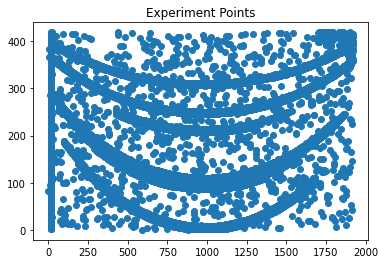

In [9]:
row, col = roi.nonzero()
or_pts = np.column_stack((col, row)) # this are the points

plt.figure()
plt.scatter(or_pts[:, 0], or_pts[:, 1])
plt.title('Input points')
print ("num of points {}".format(or_pts.shape))

# add + 25% random
noise = get_random(or_pts, round(or_pts.shape[0] * 0.05))
pts = add_random(or_pts, noise)
print ("num of points with random {}".format(pts.shape[0]))
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
plt.title('Experiment Points')

In [10]:
# Minimal sample set
def get_minimal_set(pts, number_minimal_pts = 3, debug=False):
    this_pts = pts.copy()
    sample_pts = []
    sample_indices = []
    
    for i in range(number_minimal_pts):
        sample_i = np.random.randint(low=0, high=roi.shape[0])
        sample_indices.append(sample_i)
        sample_pts.append(this_pts[sample_i])
        this_pts = np.delete(this_pts, sample_i, 0)
    # convert to numpy arrays
    sample_pts     = np.array(sample_pts)
    sample_indices = np.array(sample_indices, dtype=int) 
    
    if debug:
        #print("sample set: \n\t{}\n sample_indices:\n\t {}\n new pts shape: \n\t{}".format(sample_pts, sample_indices, this_pts.shape))
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        x = this_pts[:, 0]
        y = this_pts[:, 1]
        plt.plot(x, y, 'r.')
        
        sample_x = sample_pts[:, 0]
        sample_y = sample_pts[:, 1]
        plt.plot(sample_x, sample_y, 'g.')

    return sample_pts, this_pts, sample_indices


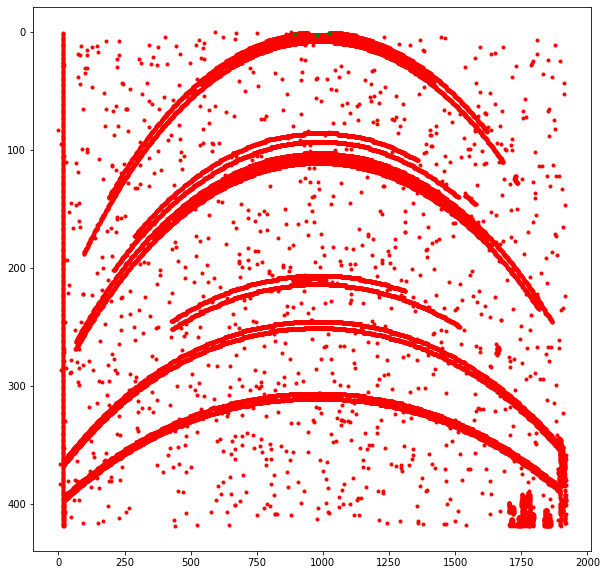

In [11]:
sample, new_pts, _ = get_minimal_set(pts, debug=True)


In [12]:
from numpy.polynomial import Chebyshev as T

def get_parabola_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    parabola = T.fit(x, y, deg=2, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, parabola(x_axis), 'b')
    return parabola

def get_line_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    line = T.fit(x, y, deg=1, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, line(x_axis), 'b')
    return line


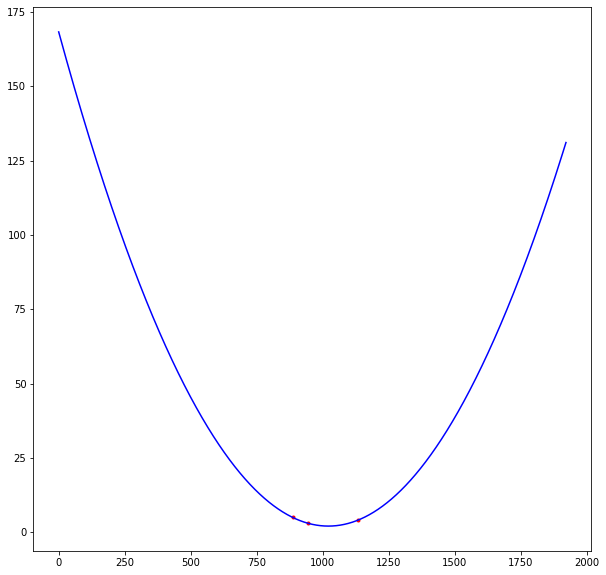

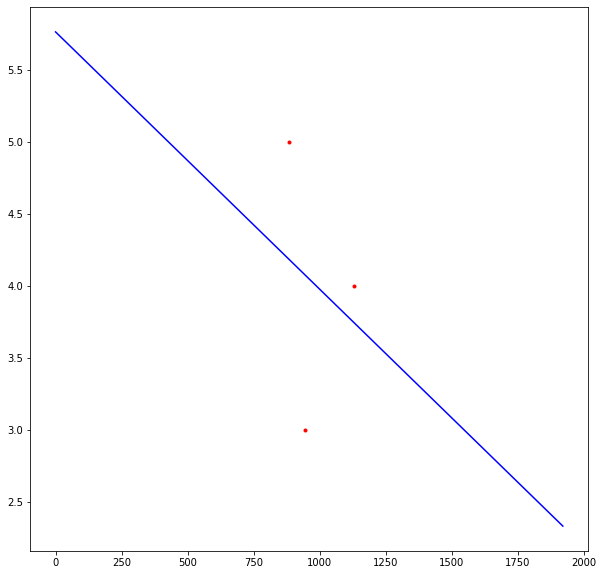

In [13]:
parabola = get_parabola_from_set(sample, debug=True)
line = get_line_from_set(sample, debug=True)

In [13]:
import time
def get_models(pts, number_models=10, type_models='line', number_minimal_pts=3, debug=False, step_debug=20, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()

    if type_models=='line':
        for j in range(number_models):
            sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
            line_j            = get_line_from_set(sample_j, debug=debug) 
            models.append(line_j)
    
            if overwrite:
                pts = new_pts
    
            # step time end
            if j % step_debug == 0:
                end_time = time.time()
                elapsed = end_time - step_time
                print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
                step_time = time.time()    
    
    elif type_models=='parabola':
        for j in range(number_models):
            sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
            parabola_j        = get_parabola_from_set(sample_j, debug=debug) 
            models.append(parabola_j)

            if overwrite:
                pts = new_pts

            # step time end
            if j % step_debug == 0:
                end_time = time.time()
                elapsed = end_time - step_time
                print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
                step_time = time.time()
        
        
    else:
        print ("no models specified. available models are: 'line', 'parabola'")
        return None
    
    

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
        
    return models
    

In [15]:
from scipy.optimize import curve_fit

def optimize_line(x, a, b):
    return a * x + b

def optimize_parabola(x, a, b, c):
    return a * x + b * x **2 + c


In [16]:
parameters, _ = curve_fit(optimize_line, [1072,  944, 1014], [1, 1, 3])


0.0009737098322913917 0.6832197338509748


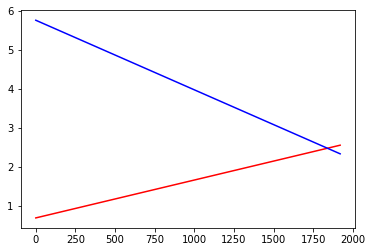

In [17]:
m, q = parameters
x = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
y = m*x + q
plt.plot(x, y, 'r')
print(m, q)

y=line(x)
plt.plot(x, y, 'b')
plt.show()

1
2
5.764646444233373 - 0.0017884930178040932·x¹ [ 5.76464644e+00 -1.78849302e-03]
3.9618454822868467 - 0.21998464118990343·T₁(x) [ 3.96184548 -0.21998464]
-0.0017884930178040932 5.764646444233373


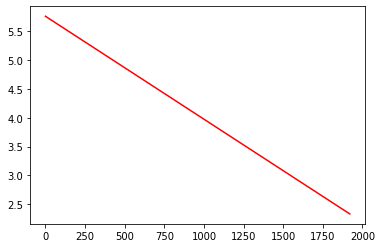

In [18]:
from numpy import polynomial as P
print(line.degree())
print(parabola.degree())
p = line.convert(kind=P.Polynomial)
print(p, p.coef)
print(line, line.coef)

q, m = p.coef 
x = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
y = m*x + q
plt.plot(x, y, 'r')
print(m, q)


In [72]:
from numpy import polynomial as P

def evaluate_preference(point, model, type_error='distance', thr=0.25*roi.shape[0], debug=False):
    x = point[0]
    y = point[1]
    
    y_pred = model(x)
    
    if type_error=='distance':
        p = model.convert(kind=P.Polynomial)
        if model.degree() == 1:
            q, m = p.coef
            err = np.abs(m*x - y + q)/np.sqrt(m**2 + (-1)**2)
        if model.degree() == 2:
            print('not implemented for parabola')
            err = 0
    
    elif type_error=='y_distance':
        err = np.abs(model(x) - y)
    
    else:
        print ("no implementation found for type_error {}".format(type_error))
        return 0
    
    binerr = 1 if err <= thr else 0
    if debug:
        print("point: {}, y_predicted: {}, error: {}, binerror: {}".format(point, y_pred, err, binerr))
    return err

In [14]:
# Preference matrix utils
import seaborn as sn
import time

def print_preference_space(preference_matrix):
    x, y = preference_matrix.nonzero()

    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()
    plt.plot(x, y, 'r.')

def print_preference_matrix(matrix):
    fig, ax = plt.subplots(figsize=(15,15))         
    sn.heatmap(matrix, cmap="binary", yticklabels=False)
    print_preference_space(matrix)


def get_preference_matrix(pts : np.array, models : np.array,  type_error='y_distance', thr=0.25*roi.shape[0], limit=np.inf, step_debug=50, debug=False):

    print("Threshold for preference selected: {}".format(thr))
    
    # time utils
    start_time = time.time()
    
    matrix = np.zeros(shape=(pts.shape[0], len(models)), dtype=int)    

    step_time = time.time()
    i = 0
    for p in pts:
        if i == limit:
            break
        
        for j in range(len(models)):
            
            preference = evaluate_preference(p, models[j], debug=debug, type_error=type_error, thr=thr)
            matrix[i, j] = preference
        
        # step time end
        if i % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(i, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()
        i += 1
    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    return matrix



0] took: 0.00436 s
Completed! total time: 00 h 00 m 00 s
0] took: 0.00020 s
50] took: 0.00938 s
Completed! total time: 00 h 00 m 00 s


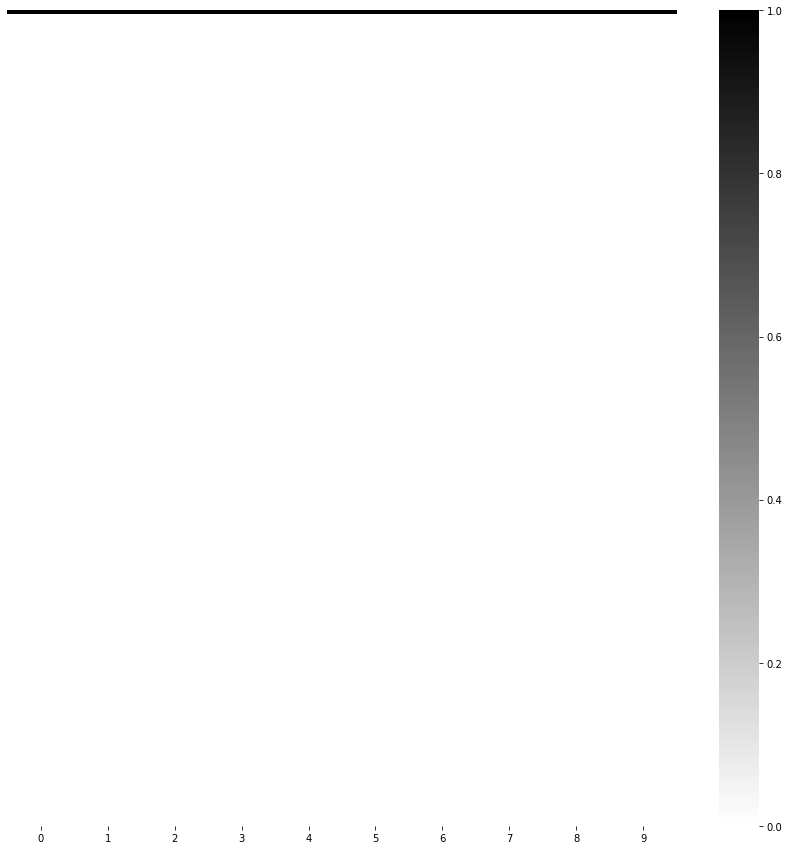

In [18]:
models = init_columns(pts)
preference_matrix = get_preference_matrix(pts, models, limit=100)
print_preference_matrix(preference_matrix)

### Let's do it for all points

0] took: 0.00296 s
20] took: 0.02028 s
40] took: 0.01489 s
60] took: 0.01865 s
80] took: 0.01602 s
100] took: 0.01596 s
120] took: 0.01321 s
140] took: 0.01146 s
160] took: 0.01108 s
180] took: 0.01154 s
Completed! total time: 00 h 00 m 00 s
points: (24153, 2), models: 200
0] took: 0.00217 s
5000] took: 0.45055 s
10000] took: 0.98858 s
15000] took: 0.88751 s
20000] took: 0.09055 s
Completed! total time: 00 h 00 m 39 s


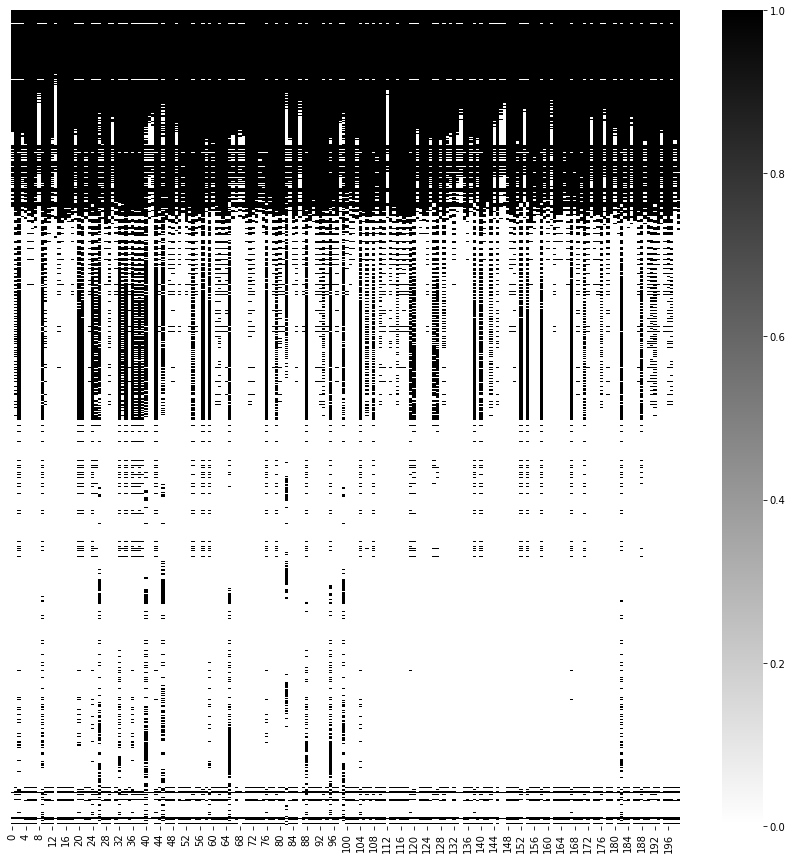

In [39]:
models = init_columns(pts, number_columns=200)
print("points: {}, models: {}".format(pts.shape, len(models)))
preference_matrix = get_preference_matrix(pts, models, debug=False, step_debug=5000)
print_preference_matrix(preference_matrix)


In [40]:
preference_matrix.shape

(24153, 200)

In [55]:
def print_preference_space(preference_matrix):
    x, y = preference_matrix.nonzero()

    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()
    plt.plot(x, y, 'r.')


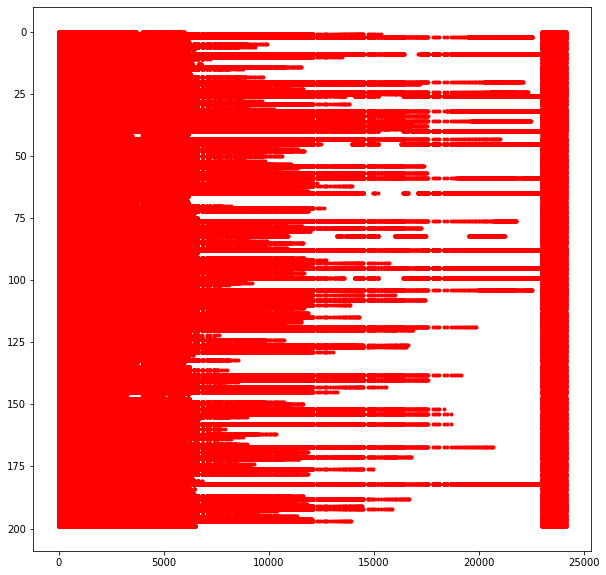

In [56]:
print_preference_space(preference_matrix)

# Line

num of pts 23003, num of noise 1150
0] took: 0.00231 s
20] took: 0.01937 s
40] took: 0.01941 s
60] took: 0.01414 s
80] took: 0.01057 s
100] took: 0.01001 s
120] took: 0.01124 s
140] took: 0.00967 s
160] took: 0.00883 s
180] took: 0.00865 s
200] took: 0.00781 s
220] took: 0.00800 s
240] took: 0.00867 s
260] took: 0.00765 s
280] took: 0.00911 s
300] took: 0.00777 s
320] took: 0.00820 s
340] took: 0.00770 s
360] took: 0.00853 s
380] took: 0.00784 s
400] took: 0.01357 s
420] took: 0.01212 s
440] took: 0.01126 s
460] took: 0.00941 s
480] took: 0.00798 s
Completed! total time: 00 h 00 m 00 s
Threshold for preference selected: 105.0
0] took: 0.08509 s
1000] took: 0.55670 s
2000] took: 0.22238 s
3000] took: 0.87944 s
4000] took: 0.18696 s
5000] took: 0.26932 s
6000] took: 0.94058 s
7000] took: 0.97268 s
8000] took: 0.46041 s
9000] took: 0.20949 s
10000] took: 0.14342 s
11000] took: 0.35501 s
12000] took: 0.38101 s
13000] took: 0.34422 s
14000] took: 0.15228 s
15000] took: 0.41126 s
16000] took

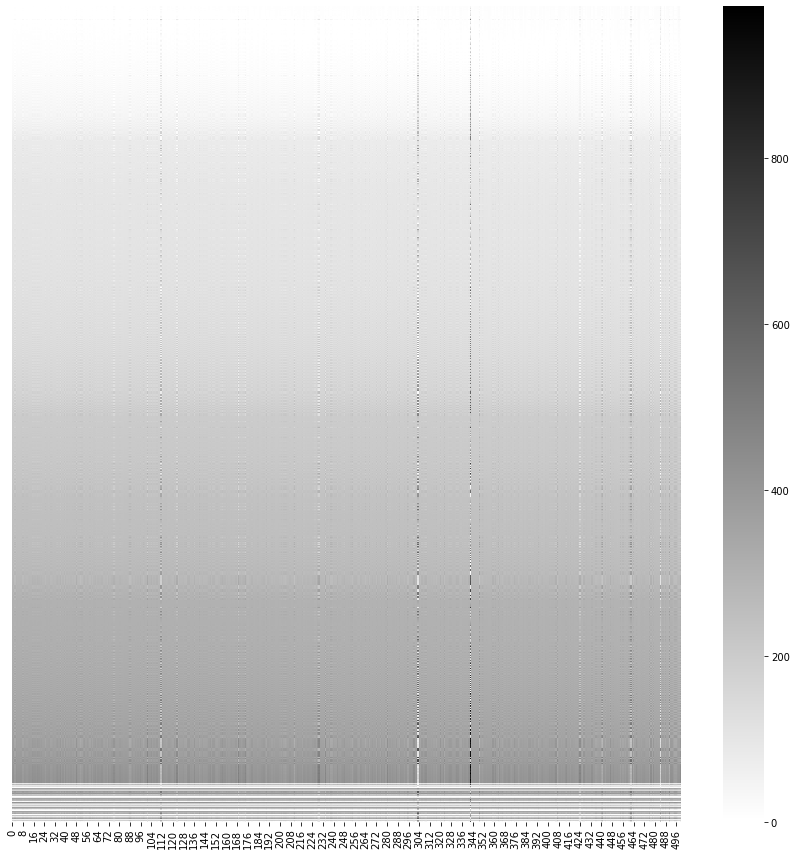

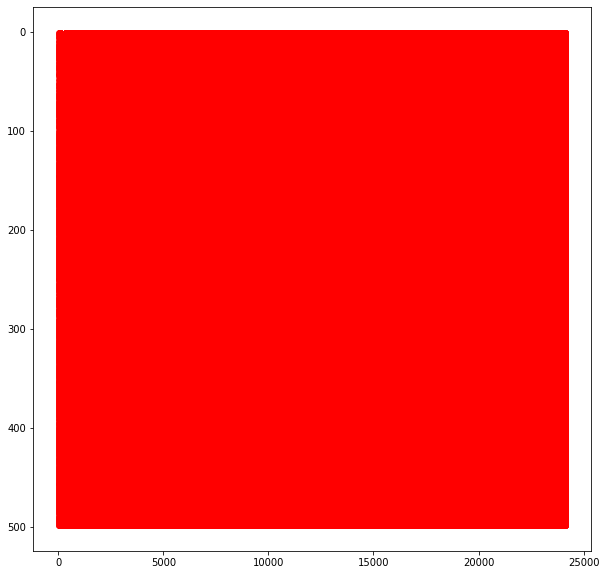

In [97]:
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points

# add + 5% random
noise = get_random(pts, qty_noise=round(or_pts.shape[0] * 0.05), debug=False)
pts   = add_random(pts, noise, debug=False)

# get models
models = get_models(pts, number_models=500, type_models='line', number_minimal_pts=3, debug=False, step_debug=20, overwrite=True)

# preference matrix
preference_matrix = get_preference_matrix(pts, models, type_error='distance', step_debug=1000, debug=False)
print_preference_matrix(preference_matrix)

In [98]:
backup_matrix = preference_matrix.copy()

In [99]:
preference_matrix.mean()

183.85049989649318

In [100]:
preference_matrix[preference_matrix>preference_matrix.mean()] = 0

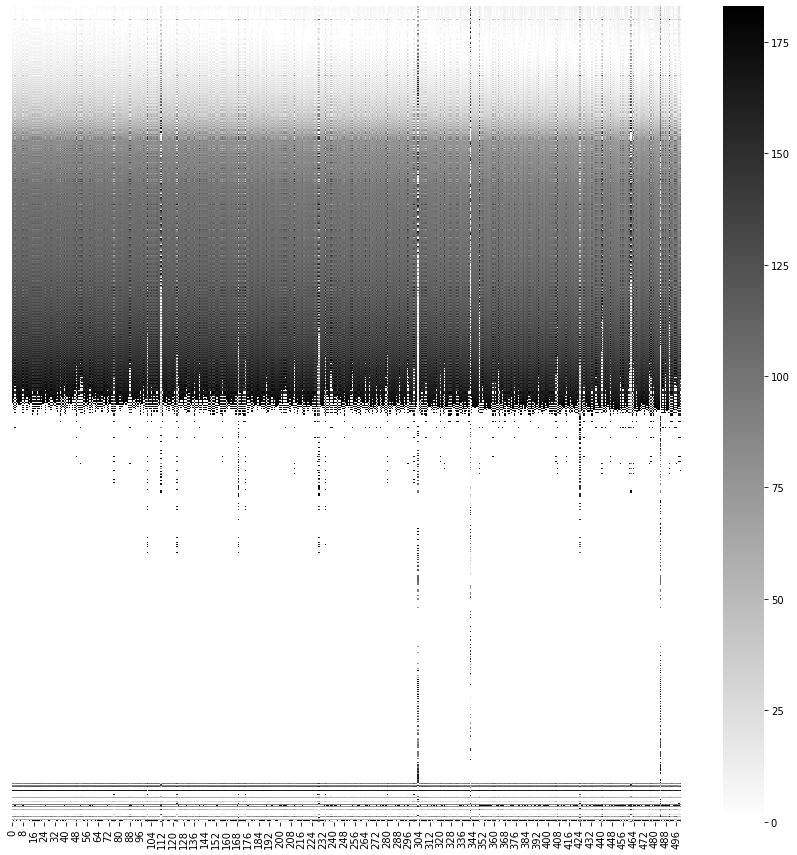

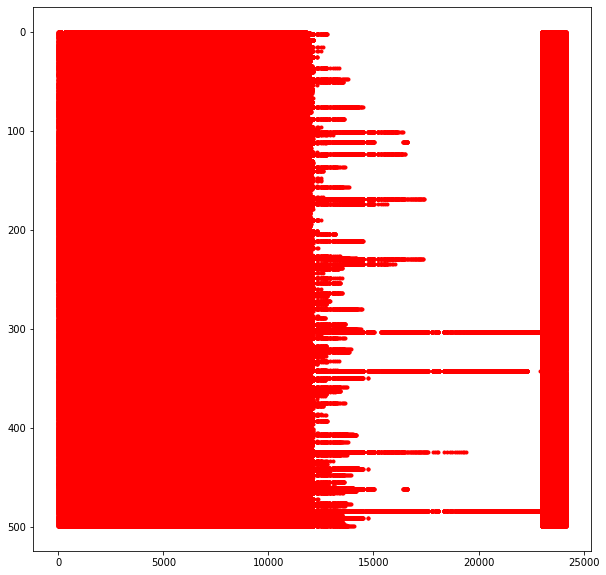

In [101]:
print_preference_matrix(preference_matrix)

num of pts 23003, num of noise 1150
0] took: 0.00095 s
50] took: 0.04166 s
100] took: 0.03710 s
150] took: 0.02750 s
200] took: 0.02603 s
250] took: 0.02737 s
300] took: 0.02585 s
350] took: 0.03030 s
400] took: 0.03360 s
450] took: 0.02764 s
Completed! total time: 00 h 00 m 00 s
Threshold for preference selected: 105.0
0] took: 00 h 00 m 00 s
1000] took: 00 h 00 m 05 s
2000] took: 00 h 00 m 05 s
3000] took: 00 h 00 m 05 s
4000] took: 00 h 00 m 04 s
5000] took: 00 h 00 m 05 s
6000] took: 00 h 00 m 04 s
7000] took: 00 h 00 m 05 s
8000] took: 00 h 00 m 05 s
9000] took: 00 h 00 m 05 s
10000] took: 00 h 00 m 04 s
11000] took: 00 h 00 m 05 s
12000] took: 00 h 00 m 04 s
13000] took: 00 h 00 m 05 s
14000] took: 00 h 00 m 04 s
15000] took: 00 h 00 m 05 s
16000] took: 00 h 00 m 04 s
17000] took: 00 h 00 m 05 s
18000] took: 00 h 00 m 05 s
19000] took: 00 h 00 m 04 s
20000] took: 00 h 00 m 04 s
21000] took: 00 h 00 m 04 s
22000] took: 00 h 00 m 04 s
23000] took: 00 h 00 m 05 s
24000] took: 00 h 0

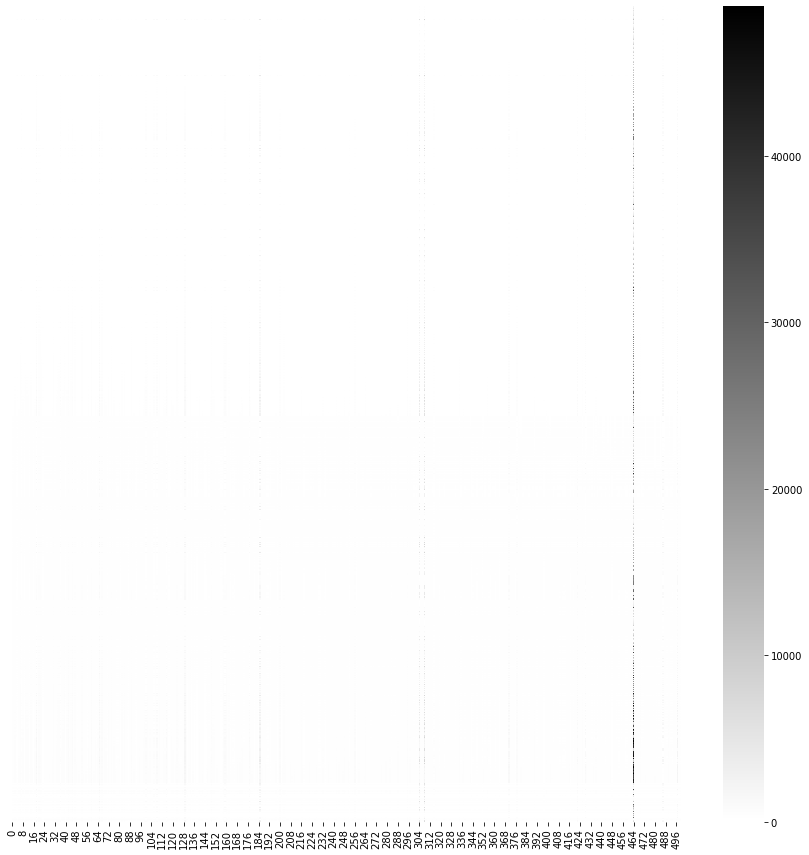

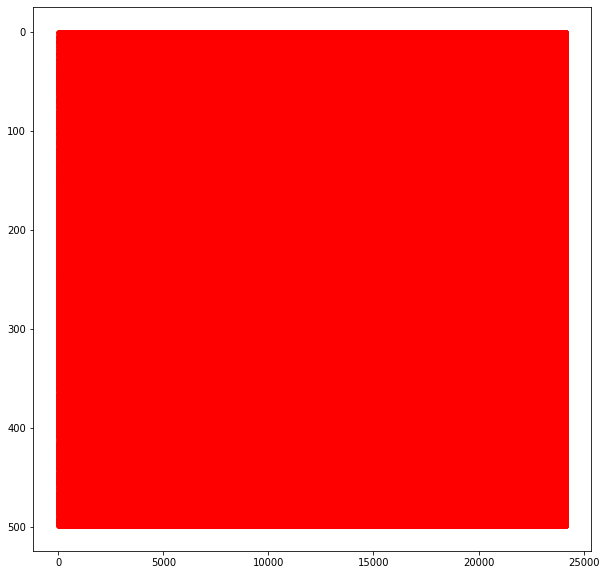

In [74]:
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points

# add + 5% random
noise = get_random(pts, qty_noise=round(or_pts.shape[0] * 0.05), debug=False)
pts   = add_random(pts, noise, debug=False)

# get models
models = get_models(pts, number_models=500, type_models='parabola', number_minimal_pts=5, debug=False, step_debug=50, overwrite=True)

# preference matrix
preference_matrix_p = get_preference_matrix(pts, models, type_error='y_distance', step_debug=1000, debug=False)
print_preference_matrix(preference_matrix_p)

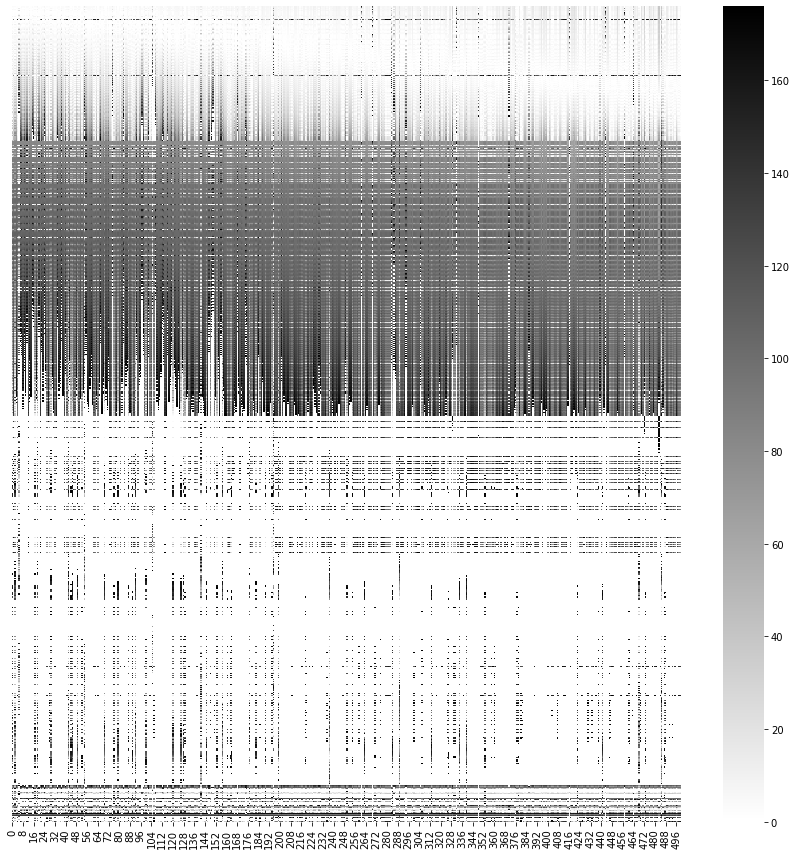

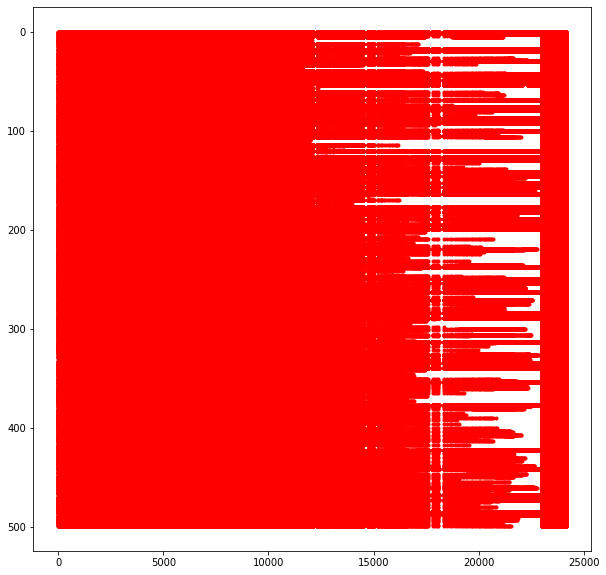

In [104]:
backup_matrix_par = preference_matrix_p.copy()
preference_matrix_p[preference_matrix_p>preference_matrix_p.mean()] = 0
print_preference_matrix(preference_matrix_p)

In [21]:
def get_preference_matrix_optimized(pts : np.array, models : np.array, thr=roi.shape[0], limit=np.inf, step_debug=50, debug=False):

    print("Threshold for preference selected: {}".format(thr))
    
    # time utils
    start_time = time.time()
    
    x = pts[:, 0]
    y = pts[:, 1]
    matrix = np.array([])
    
    step_time = time.time()
    i = 0
    for m in models:
        if i == limit:
            break
        
        if len(matrix) == 0 :
            matrix = np.abs(y - m(x))
        else:
            matrix = np.column_stack([matrix, np.abs(y - m(x).astype(np.int32))])
        
        # step time end
        if i % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(i, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()
        i += 1
        
    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    matrix[matrix > thr] = 0
    return matrix



In [101]:
matrix_2 = get_preference_matrix_optimized(pts, models, step_debug=100)


Threshold for preference selected: 105.0
0] took: 00 h 00 m 00 s
100] took: 00 h 00 m 00 s
200] took: 00 h 00 m 00 s
300] took: 00 h 00 m 01 s
400] took: 00 h 00 m 01 s
Completed! total time: 00 h 00 m 06 s


In [102]:
matrix_2.shape

(24153, 500)

In [103]:
preference_matrix_p[0:, ] == matrix_2[0:, ]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [104]:
preference_matrix_p[0:, ]

array([[152,  48,  44, ..., 342,  96, 212],
       [  1,   1,   0, ...,  90,  18,   2],
       [  1,   1,   0, ...,  91,  18,   2],
       ...,
       [ 76,  25, 116, ..., 402,  22, 135],
       [300, 299, 299, ..., 492, 282, 304],
       [ 49,  63,  78, ...,  39,  41,  44]])

In [105]:
matrix_2[0:, ]

array([[152,  48,  44, ..., 342,  96, 212],
       [  1,   1,   0, ...,  90,  18,   2],
       [  1,   1,   0, ...,  91,  18,   2],
       ...,
       [ 76,  25, 116, ..., 402,  22, 135],
       [300, 299, 299, ..., 492, 282, 304],
       [ 49,  63,  78, ...,  39,  41,  44]])

num of pts 23003, num of noise 1150
0] took: 00 h 00 m 00 s
Completed! total time: 00 h 00 m 00 s
Threshold for preference selected: 420
0] took: 00 h 00 m 00 s
Completed! total time: 00 h 00 m 00 s


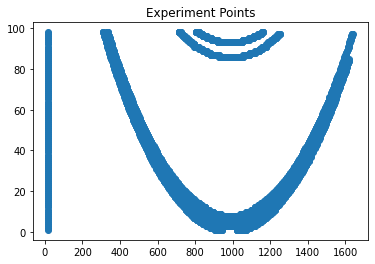

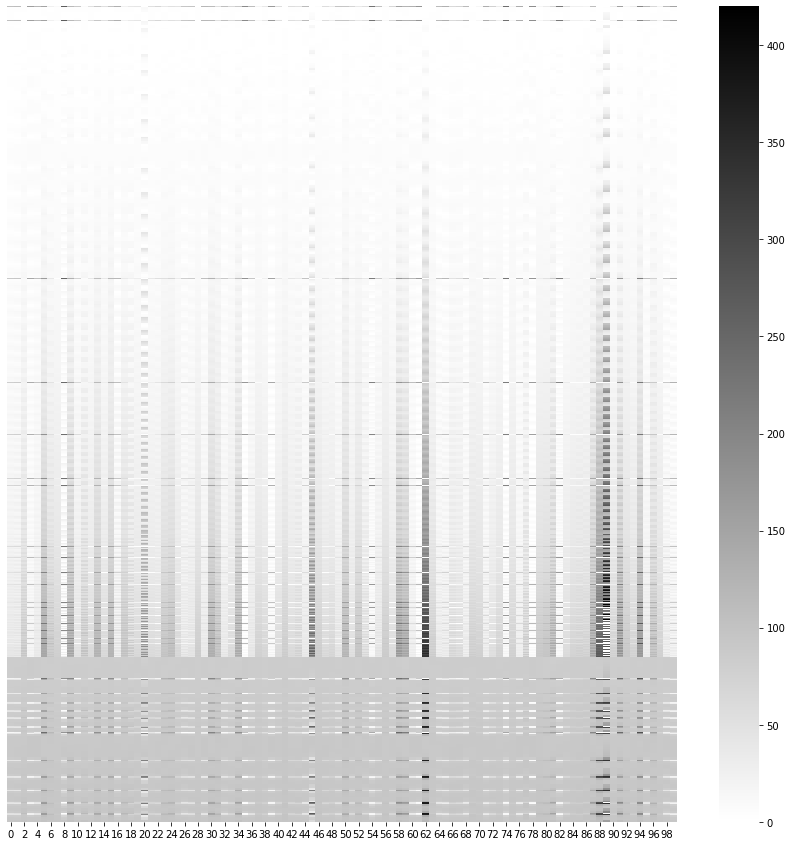

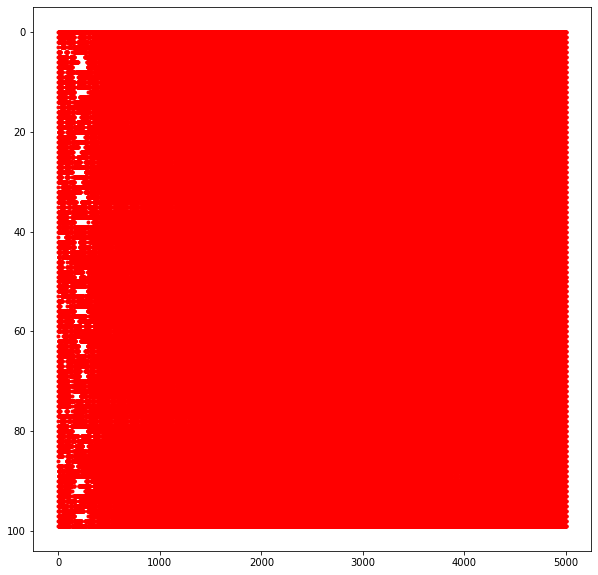

In [55]:
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points

# add + 5% random
noise = get_random(pts, qty_noise=round(or_pts.shape[0] * 0.05), debug=False)
pts   = add_random(pts, noise, debug=False)

# cut pts
pts = pts[0:5000, :]
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
plt.title('Experiment Points')

# get models
models = get_models(pts, number_models=100, type_models='parabola', number_minimal_pts=5, debug=False, step_debug=10000, overwrite=False)

# preference matrix
matrix = get_preference_matrix_optimized(pts, models, step_debug=1000, debug=False)
print_preference_matrix(matrix)

In [56]:
def print_model(model):
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'b')

def print_pts(pts):
    plt.figure()
    plt.scatter(pts[:, 0], pts[:, 1])
    plt.title('Experiment Points')

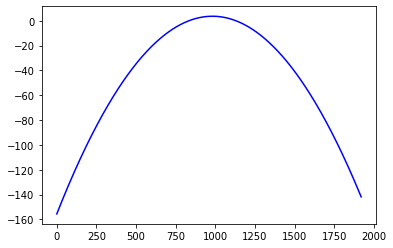

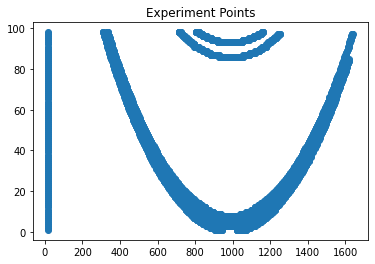

In [57]:
# cluster in preference space
print_model(models[5])
print_pts(pts)

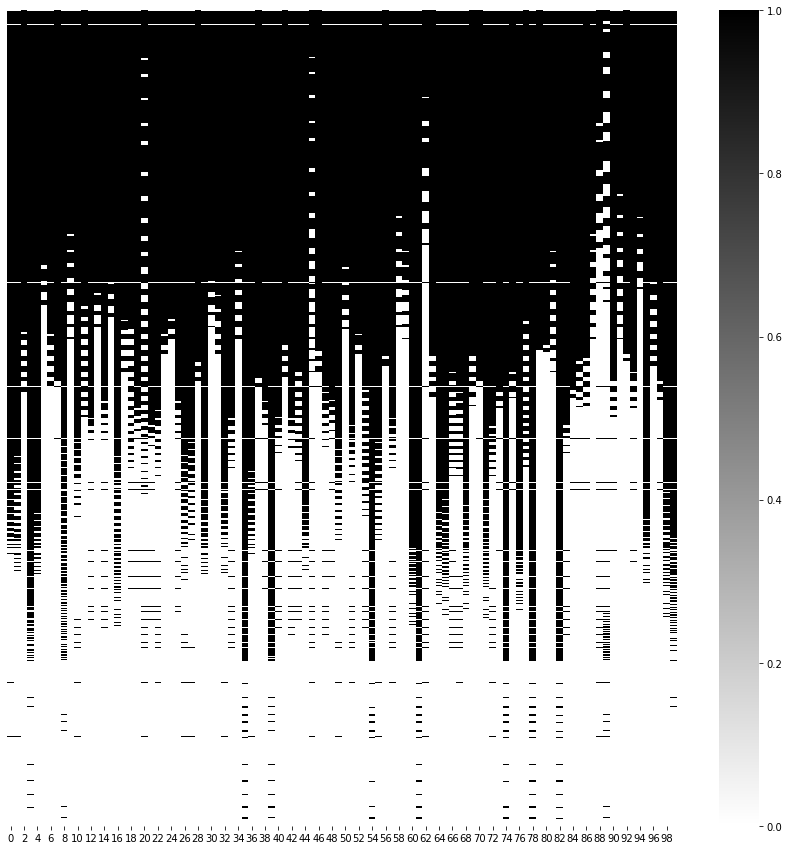

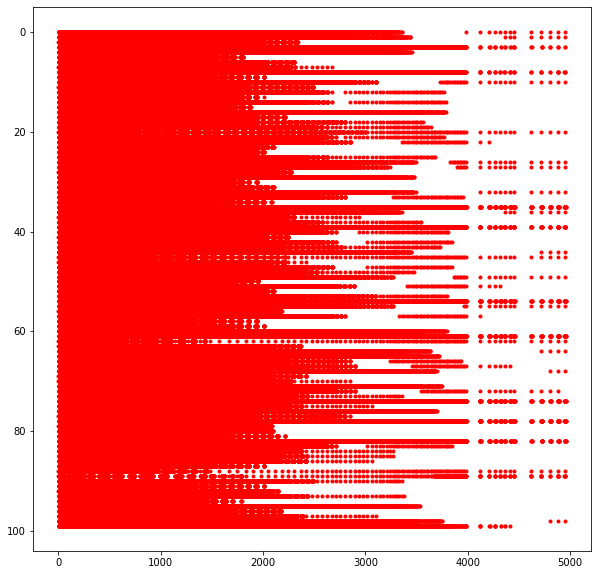

In [60]:
mask = (matrix < 20).astype(int)
print_preference_matrix(mask)

num_clusters:	 2
cluster labels:
 [0 1]


(array([0, 1, 1, ..., 1, 1, 1]), 2, array([0, 1]))

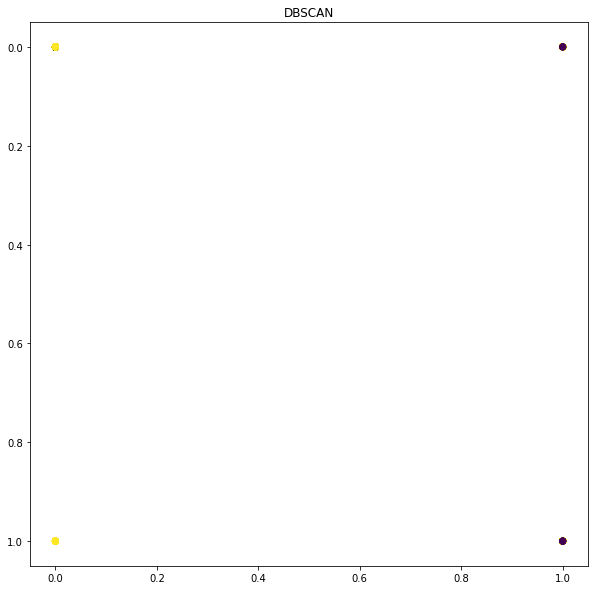

In [62]:
clusterize(mask)

num_clusters:	 7
cluster labels:
 [-1  0  1  2  3  4  5]


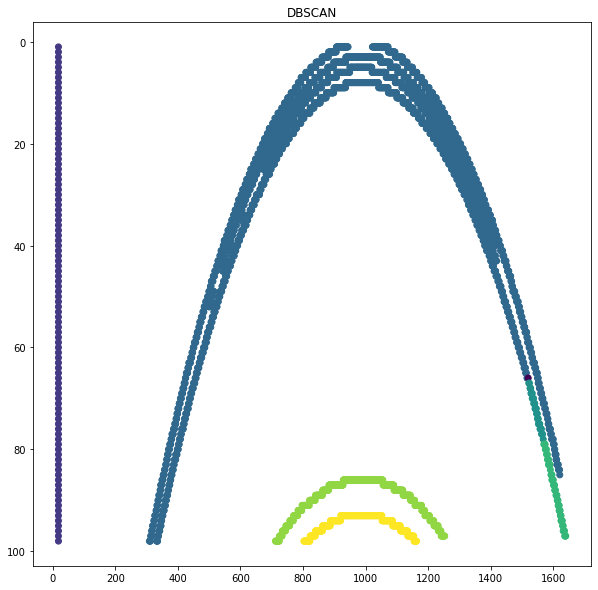

In [92]:
# print clusters
x, y = mask.nonzero()
p = np.column_stack([x, y])
pts_clusters, num_clusters, clusters_label = clusterize(pts)
all_clusters = get_all_clusters(p)

In [93]:
clusters_label

array([-1,  0,  1,  2,  3,  4,  5])

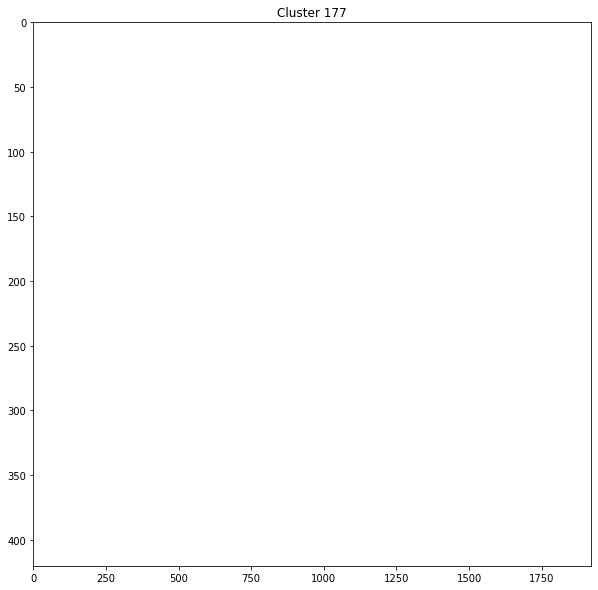

In [94]:
print_cluster(all_clusters[3], p, 177)

In [91]:
all_clusters[3]

array([234499, 234525, 234551, 234577, 234603, 234629, 234655])